In [1]:
import numpy as np
import osmnx as ox

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time
import random
import pickle

import mlrfit as mf

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

#  Matrix definition

In [3]:
rank = 30
symm = False

place = "Pacifica, CA, USA"
G, Adj, Dist = mf.dist_matrix_osmnx(place)
mtype = "dist_pacifica"
A = Dist
m = n = A.shape[0]

As = {'dist' : A}

diam_G = A.max()
w_min = A[A>0].min()
print(m, diam_G, w_min, (Adj>0).sum())

degrees: {0: 0, 1: 4, 2: 234, 3: 49, 4: 53, 5: 44, 6: 469, 7: 5, 8: 71, 9: 0, 10: 2}
931 52.0 0.5 2395


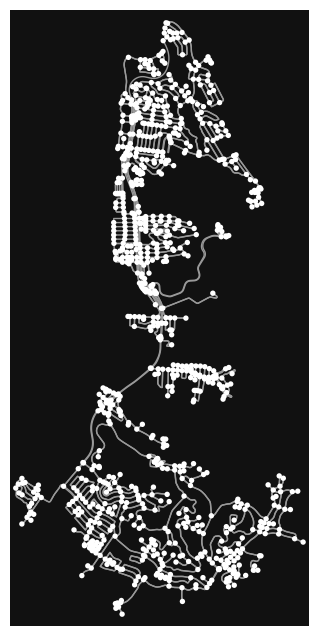

In [4]:
fig, ax = ox.plot_graph(G)

In [5]:
U, Vt, sigmas = mf.frob_low_rank(A)
frob_losses = np.zeros(m)
normalization = np.linalg.norm(A, ord='fro')
# assert np.allclose(normalization, ((sigmas**2).sum())**0.5)
sigmas2 = (sigmas**2)[::-1]
frob_losses = np.concatenate([(np.cumsum(sigmas2)**0.5)[::-1][1:] / normalization, np.array([0])])

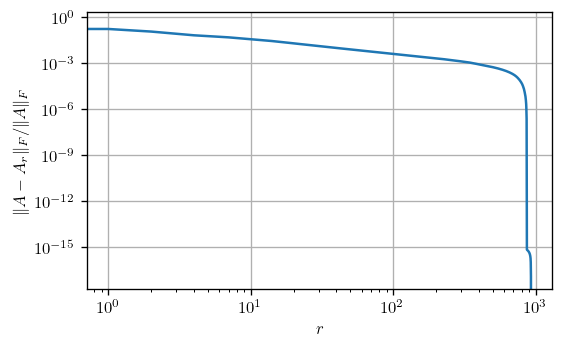

In [6]:
mf.plot_frob_error_rank(frob_losses)

In [7]:
eps_ff = 1e-2
eps = 1e-3

In [8]:
method = 'bcd'
svds_v0 = True
max_iters_ff = 2
max_iters = 3*10**3
grref_max_iters = 5000
PSD = False
refined = True
symm = np.allclose(A, A.T) if m==n else False
print(f"{symm=}")

filename = "%s_r%d_%d"%(mtype, rank, n)

symm=True


# Rank allocation + spectral partitioning + greedy refinement

In [9]:
info = {} 

In [10]:
# LR
hpart = mf.random_hpartition(m, n, num_levels=1, symm=symm, perm=False)
B1, C1 = mf.single_level_factor_fit(A, np.array([rank]), hpart, level=0, symm=symm, PSD=PSD)[:2]
info['LR'] = {'loss':[mf.rel_diff(B1 @C1.T, den=A)]}
print(info['LR']['loss'])

[0.013659416123329568]


In [11]:
# LR+D fitting
hpart = mf.random_hpartition(m, n, level_list=[0, int(np.log2(m))+1], symm=symm, perm=False)
assert hpart['rows']['lk'][1].size == min(m,n)+1
ranks = np.array([rank-1, 1])
hat_A = mf.MLRMatrix(hpart=hpart, ranks=ranks)
start_time = time.time()
fa_losses = hat_A.factor_fit(A, ranks, hat_A.hpart, method=method, eps_ff=eps_ff/10000, \
                                  freq=100, svds_v0=svds_v0,\
                                  printing=False, max_iters_ff=max_iters, symm=symm, warm_start=False)
fa_time = time.time()-start_time
info['LR+D'] = {'loss':fa_losses, 'time':fa_time}
print(f"{fa_losses[-1]=} {len(fa_losses)} time={fa_time:.3f}")

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/mlrfit-0.0.1-py3.9.egg/mlrfit/utils.py:433: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  hat_A_except_level[r1:r2, c1:c2] += np.dot(B_level[r1:r2], C_level[c1:c2].T)


fa_losses[-1]=0.012958735835490344 5 time=10.728


In [12]:
num_levels = int(np.ceil(np.log2(min(m,n)))+1)

In [13]:
# uniform rank initialization + spectral hierarchy + rank allocation
ranks = mf.uniform_ranks(rank, num_levels) 
print(ranks)
hat_A = mf.MLRMatrix()
start_time = time.time()
td_losses, _ = hat_A.hpartition_topdown(A, ranks, eps_ff=eps_ff, symm=symm, max_iters_ff=1, \
                                        PSD=PSD, grref_max_iters=grref_max_iters)
td_time = time.time()-start_time
print(f"{td_losses[-1]=} time={td_time:.3f}")
start_time = time.time()
ra_losses, epochs, ranks_history_uni = hat_A.rank_alloc(A, ranks, hat_A.hpart, freq=1,\
                        eps=eps, eps_ff=eps_ff, max_iters=max_iters, PSD=PSD, symm=symm,\
                        max_iters_ff=max_iters_ff, warm_start=True)
ra_time = time.time()-start_time
info['MLR uniform'] = {'loss':ra_losses, 'td_time':td_time, 'ra_time':ra_time, 'epochs':epochs}
print(f"td+ra time={ra_time:.3f}")
assert np.allclose(ra_losses[0], td_losses[-1]), print(ra_losses[0], td_losses[-1])

del hat_A

[3 3 3 3 3 3 3 3 2 2 2]
* level=0, losses[0]=0.114, losses[-1]=0.114, len(losses)=2, [3]


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


* level=1, losses[0]=0.051, losses[-1]=0.050, len(losses)=2, [3 3]
* level=2, losses[0]=0.033, losses[-1]=0.032, len(losses)=2, [3 3 3]
* level=3, losses[0]=0.026, losses[-1]=0.026, len(losses)=2, [3 3 3 3]
* level=4, losses[0]=0.024, losses[-1]=0.024, len(losses)=2, [3 3 3 3 3]
* level=5, losses[0]=0.023, losses[-1]=0.022, len(losses)=2, [3 3 3 3 3 3]
* level=6, losses[0]=0.022, losses[-1]=0.022, len(losses)=2, [3 3 3 3 3 3 3]
* level=7, losses[0]=0.021, losses[-1]=0.021, len(losses)=2, [3 3 3 3 3 3 3 3]
* level=8, losses[0]=0.021, losses[-1]=0.021, len(losses)=2, [3 3 3 3 3 3 3 3 2]
* level=9, losses[0]=0.021, losses[-1]=0.021, len(losses)=2, [3 3 3 3 3 3 3 3 2 2]
* level=10, losses[0]=0.021, losses[-1]=0.021, len(losses)=2, [3 3 3 3 3 3 3 3 2 2 2]
level=10, loss=0.020602404791350212
td_losses[-1]=0.020602404791350212 time=67.590
itr=0, t=4, losses[0]=0.020602404791350212, losses[-1]=0.020338060309463467, [3 3 3 3 3 3 3 3 2 2 2]
itr=1, t=7, 0.014441497849630983, [4 3 3 3 3 3 3 3 2 2 

In [14]:
# bottom rank initialization + spectral hierarchy + rank allocation
ranks = np.array((num_levels-1)*[0]+[rank]) 
print(ranks)
hat_A = mf.MLRMatrix()
start_time = time.time()
td_losses, _ = hat_A.hpartition_topdown(A, ranks, eps_ff=eps_ff, symm=symm, max_iters_ff=1, \
                                        PSD=PSD, grref_max_iters=grref_max_iters)
td_time = time.time()-start_time
print(f"{td_losses[-1]=} time={td_time:.3f}")
start_time = time.time()
ra_losses, epochs, ranks_history_bottom = hat_A.rank_alloc(A, ranks, hat_A.hpart, freq=1,\
                        eps=eps, eps_ff=eps_ff, max_iters=max_iters, PSD=PSD, symm=symm,\
                        max_iters_ff=max_iters_ff, warm_start=True)
ra_time = time.time()-start_time
info['MLR bottom'] = {'loss':ra_losses, 'td_time':td_time, 'ra_time':ra_time, 'epochs':epochs}
print(f"td+ra time={ra_time:.3f}")
assert np.allclose(ra_losses[0], td_losses[-1]), print(ra_losses[0], td_losses[-1])

del hat_A

[ 0  0  0  0  0  0  0  0  0  0 30]
* level=0, losses[0]=1.000, losses[-1]=1.000, len(losses)=2, [0]
* level=1, losses[0]=1.000, losses[-1]=1.000, len(losses)=2, [0 0]
* level=2, losses[0]=1.000, losses[-1]=1.000, len(losses)=2, [0 0 0]
* level=3, losses[0]=1.000, losses[-1]=1.000, len(losses)=2, [0 0 0 0]
* level=4, losses[0]=1.000, losses[-1]=1.000, len(losses)=2, [0 0 0 0 0]
* level=5, losses[0]=1.000, losses[-1]=1.000, len(losses)=2, [0 0 0 0 0 0]
* level=6, losses[0]=1.000, losses[-1]=1.000, len(losses)=2, [0 0 0 0 0 0 0]
* level=7, losses[0]=1.000, losses[-1]=1.000, len(losses)=2, [0 0 0 0 0 0 0 0]
* level=8, losses[0]=1.000, losses[-1]=1.000, len(losses)=2, [0 0 0 0 0 0 0 0 0]
* level=9, losses[0]=1.000, losses[-1]=1.000, len(losses)=2, [0 0 0 0 0 0 0 0 0 0]
* level=10, losses[0]=1.000, losses[-1]=1.000, len(losses)=2, [ 0  0  0  0  0  0  0  0  0  0 30]
level=10, loss=1.0
td_losses[-1]=1.0 time=55.885
itr=0, t=4, losses[0]=1.0, losses[-1]=1.0, [ 0  0  0  0  0  0  0  0  0  0 30]
i

In [15]:
# top rank initialization + spectral hierarchy + rank allocation
ranks = np.array([rank]+(num_levels-1)*[0])
print(ranks)
hat_A = mf.MLRMatrix()
start_time = time.time()
td_losses, _ = hat_A.hpartition_topdown(A, ranks, eps_ff=eps_ff, symm=symm, max_iters_ff=1, \
                                        PSD=PSD, grref_max_iters=grref_max_iters)
td_time = time.time()-start_time
print(f"{td_losses[-1]=} time={td_time:.3f}")
start_time = time.time()
ra_losses, epochs, ranks_history_top = hat_A.rank_alloc(A, ranks, hat_A.hpart, freq=1,\
                        eps=eps, eps_ff=eps_ff, max_iters=max_iters, PSD=PSD, symm=symm,\
                        max_iters_ff=max_iters_ff, warm_start=True)
ra_time = time.time()-start_time
info['MLR top'] = {'loss':ra_losses, 'td_time':td_time, 'ra_time':ra_time, 'epochs':epochs}
print(f"td+ra time={ra_time:.3f}")
assert np.allclose(ra_losses[0], td_losses[-1]), print(ra_losses[0], td_losses[-1])

del hat_A

[30  0  0  0  0  0  0  0  0  0  0]
* level=0, losses[0]=0.014, losses[-1]=0.014, len(losses)=2, [30]
* level=1, losses[0]=0.014, losses[-1]=0.014, len(losses)=2, [30  0]
* level=2, losses[0]=0.014, losses[-1]=0.014, len(losses)=2, [30  0  0]
* level=3, losses[0]=0.014, losses[-1]=0.014, len(losses)=2, [30  0  0  0]
* level=4, losses[0]=0.014, losses[-1]=0.014, len(losses)=2, [30  0  0  0  0]
* level=5, losses[0]=0.014, losses[-1]=0.014, len(losses)=2, [30  0  0  0  0  0]
* level=6, losses[0]=0.014, losses[-1]=0.014, len(losses)=2, [30  0  0  0  0  0  0]
* level=7, losses[0]=0.014, losses[-1]=0.014, len(losses)=2, [30  0  0  0  0  0  0  0]
* level=8, losses[0]=0.014, losses[-1]=0.014, len(losses)=2, [30  0  0  0  0  0  0  0  0]
* level=9, losses[0]=0.014, losses[-1]=0.014, len(losses)=2, [30  0  0  0  0  0  0  0  0  0]
* level=10, losses[0]=0.014, losses[-1]=0.014, len(losses)=2, [30  0  0  0  0  0  0  0  0  0  0]
level=10, loss=0.013659416123329564
td_losses[-1]=0.013659416123329564 ti

In [16]:
# mf.plot_loss_all_info(info, figsize=(7, 5), dpi=120, logscale=False, hline=True, ylim=[0, 0.1], filename='')

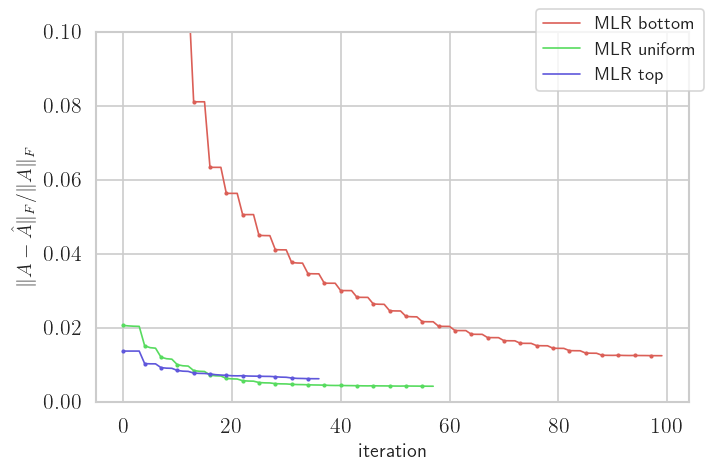

In [17]:
mf.plot_loss_all_info(info, labels=['MLR bottom', 'MLR uniform', 'MLR top'], figsize=(6, 4), dpi=120, \
                        logscale=False, hline=False, ylim=[0, 0.1], filename='')

In [18]:
for i, algo in enumerate(info.keys()):
    print(f"{algo:14s} {info[algo]['loss'][-1]}")

LR             0.013659416123329568
LR+D           0.012958735835490344
MLR uniform    0.004157415542692178
MLR bottom     0.012410069966214918
MLR top        0.006183102427767086


In [19]:
with open('outputs/info_%s.pickle'%filename, 'wb') as handle:
    pickle.dump(info, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
rh_top = np.stack(ranks_history_top, axis=0)
rh_bot = np.stack(ranks_history_bottom, axis=0)
rh_uni = np.stack(ranks_history_uni, axis=0)

with open('outputs/ranks_%s.pickle'%filename, 'wb') as handle:
    pickle.dump([rh_bot, rh_uni, rh_top], handle, protocol=pickle.HIGHEST_PROTOCOL)

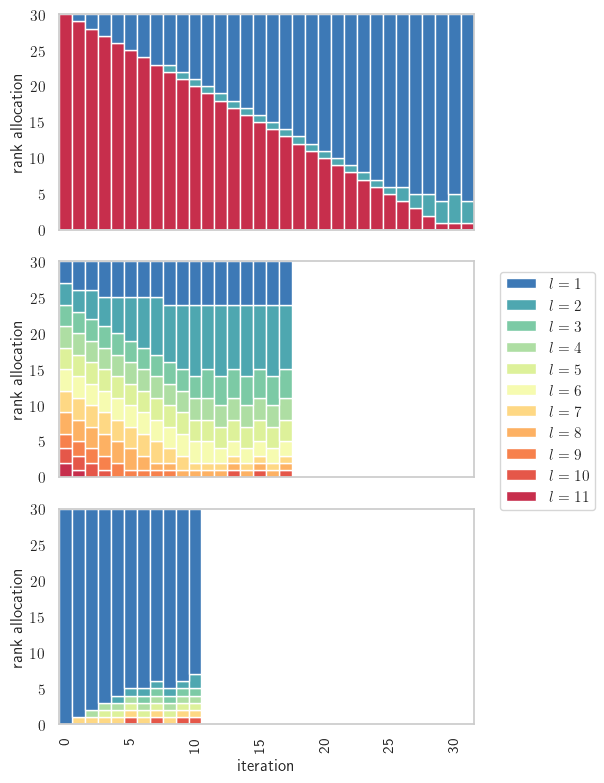

In [21]:
mf.plot_ra_evolution_col([rh_bot, rh_uni, rh_top], dpi=100, figsize=(5, 8))  #filename="plots/ra_%s.pdf"%filename)